In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
from sklearn.metrics import accuracy_score, confusion_matrix

def sigmoid(a):
    size = a.shape[0]
    output = np.zeros(size)
    for i in range(size):
        if a[i] > -100:
            output[i] = 1. / (1 + np.exp(-a[i]))
    return(output)

def softmax(x):
    # exp-normalize trick: https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
    e = np.exp(x - np.max(x))  
    if e.ndim == 1:
        return e / np.sum(e, axis=0)
    else:  
        return e / np.array([np.sum(e, axis=1)]).T 

def normalize(X):
    max_ = np.max(X,axis=0)
    min_ = np.min(X,axis=0)
    return((X - min_)/(max_ - min_))

def crossEntropy(r, y):
    return(np.sum(r*np.log(y)))

def logDiscrimination(X, Y, step = 0.1, totIter= 100, decay = 0.95):
    X = normalize(X)
    X = np.c_[np.ones(X.shape[0]).reshape(-1,1), X]
    
    totElem = X.shape[0]

    # one hot coding
    Y = Y - np.min(Y)
    n_values = np.max(Y) + 1
    Y = np.eye(n_values)[Y]

    k = Y.shape[1]
    d = X.shape[1]
    w = np.random.uniform(low = -0.01, high = 0.01, size = (k,d))
           
    for i in range(totIter):
        idx = random.sample(range(totElem), totElem)
        X = X[idx,:]
        Y = Y[idx,:]
            
        entropy = 0
        deltaW = np.zeros((k,d))
        
        for t in range(totElem):
            x = X[t,:]
            r = Y[t,:]

            o = np.dot(x, w.transpose())
            y = softmax(o)
            w += step * (r - y).reshape(k,1) * x

            #entropy += crossEntropy(r, y)
        
        step *= decay
        
        #if i % 50 == 0 or i == totIter-1:
        #    print("Entropy after epoch {0}: {1}".format(i+1, -entropy))

    return(w)

def prediction(w, x):
    x_ = np.append(1, x).astype(float)
    o_=np.dot(x_, w.transpose())
    return(np.argmax(softmax(o_)))

def backprop(X, Y, step=0.1, H=3, epoch=100, decay = 0.99):
    J = X.shape[1]
    totElem = X.shape[0]
    
    X = normalize(X)
    X = np.c_[np.ones(X.shape[0]).reshape(-1,1), X]  

    # one hot coding
    Y = Y - np.min(Y)
    n_values = np.max(Y) + 1
    Y = np.eye(n_values)[Y]
    
    I = Y.shape[1]
    
    #xavier = (6/(J+I))**0.5
    xavier = 0.01
    v = np.random.uniform(low = -xavier, high = xavier, size = (I, H+1))
    w = np.random.uniform(low = -xavier, high = xavier, size = (H, J+1))

    for e in range(epoch):
        idx = random.sample(range(totElem), totElem)
        X = X[idx,:]
        Y = Y[idx,:]
        
        for t in range(totElem):
            x = X[t,:]
            r = Y[t,:]

            z = np.ones(H+1)
            z[1:] = sigmoid(np.dot(x, w.transpose()))
            
            y = softmax(np.dot(z, v.transpose()))
            
            error = r - y
            
            deltaV = np.zeros((I, H+1))
            for h in range(H):
                deltaV[:,h] = error * z[h]
            
            deltaW = np.zeros((H, J+1))                
            for h in range(H):
                deltaW[h,:] = np.sum(error * v[:,h+1]) * z[h+1] * (1 - z[h+1]) * x 

            v += step * deltaV
            w += step * deltaW

        step *= decay
    return(v, w)
   
def feedforward(v,w, x, H):
    x_ = np.append(1, x).astype(float)
    z = np.ones(H+1)
    z[1:] = sigmoid(np.dot(x_, w.transpose()))
    y = softmax(np.dot(z, v.transpose()))
    return(y)

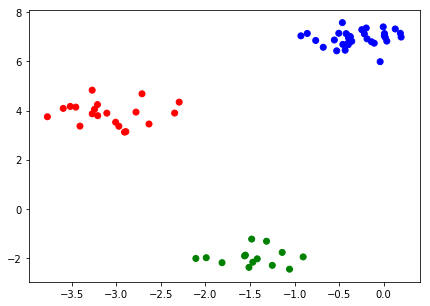

In [63]:
### TEST
np.random.seed(42)
data = pd.DataFrame(columns=['X1', 'X2', 'cluster'])

##### Cluster 1
clusterNo = 1
mean = [-3, 4]
cov = [[0.2, 0], [0, 0.2]] 
count = 20

x1, x2 = np.random.multivariate_normal(mean, cov, count).T
temp = pd.DataFrame({
    'X1': x1,
    'X2': x2,
    'cluster': np.repeat(clusterNo,count)
})
data = pd.concat([data, temp]).reset_index(drop=True)

##### Cluster 2
clusterNo = 2
mean = [-0.3, 7]
cov = [[0.1, 0], [0, 0.15]] 
count = 32

x1, x2 = np.random.multivariate_normal(mean, cov, count).T
temp = pd.DataFrame({
    'X1': x1,
    'X2': x2,
    'cluster': np.repeat(clusterNo,count)
})
data = pd.concat([data, temp]).reset_index(drop=True)

##### Cluster 3
clusterNo = 3
mean = [-1.5, -2]
cov = [[0.1, 0], [0, 0.1]] 
count = 14

x1, x2 = np.random.multivariate_normal(mean, cov, count).T
temp = pd.DataFrame({
    'X1': x1,
    'X2': x2,
    'cluster': np.repeat(clusterNo,count)
})
data = pd.concat([data, temp]).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(7,5))
colors = {'1':'red', '2':'blue', '3':'green'}
ax.scatter(data.X1, data.X2, c=data.cluster.apply(lambda x: colors[str(x)]))
plt.show()

In [64]:
hidden = 8
epoch = 300
v,w = backprop(X=data.iloc[:,[0,1]].as_matrix(), Y= data.cluster.values.astype(int), step=0.01, H=hidden, epoch=epoch, decay=1)

results = data.copy()
results['pred'] = np.repeat(-1, results.shape[0])
for i in range(results.shape[0]):
    results.iloc[i,3] = np.argmax(feedforward(v=v,w=w,x=results.iloc[i,[0,1]].as_matrix(), H = hidden))+1
    
confusion_matrix(y_true = results['cluster'].values.astype(int), y_pred = results['pred'].values)

array([[20,  0,  0],
       [ 0, 32,  0],
       [ 0,  0, 14]], dtype=int64)

In [90]:
weights = logDiscrimination(step = 0.01, decay = 1,
                            X=data.copy().iloc[:,[0,1]].as_matrix(), Y=data.copy().cluster.values.astype(int), totIter=5)

results = data.copy()
results['pred'] = np.repeat(-1, results.shape[0])
for i in range(results.shape[0]):
    results.iloc[i,3] = prediction(w=weights, x=data.iloc[i,[0,1]].as_matrix())+1
    
confusion_matrix(y_true = results['cluster'].values.astype(int), y_pred = results['pred'].values)

Entropy after epoch 1: 68.86217094543831
Entropy after epoch 5: 56.698207434412154


array([[20,  0,  0],
       [ 0, 32,  0],
       [ 1,  0, 13]], dtype=int64)

In [124]:
path = 'D:/OneDrive/Online/SelfLearn/Ryerson/MSc/2018W/DS8004/Projects/P1'
train = pd.read_csv(path+'/training.csv')
test = pd.read_csv(path+'/testing.csv')
train = train.loc[:,['class','b1', 'b4', 'b6', 'pred_minus_obs_H_b1', 'pred_minus_obs_H_b9']]
test = test.loc[:,['class','b1', 'b4', 'b6', 'pred_minus_obs_H_b1', 'pred_minus_obs_H_b9']]
train['class'] = train['class'].astype('category').cat.codes # d:0, h:1, o:2, s:3 
test['class'] = test['class'].astype('category').cat.codes # d:0, h:1, o:2, s:3 


In [92]:
weights = logDiscrimination(step = 0.01, X=train.iloc[:,range(1,6)].as_matrix(), Y=train['class'].astype(int), totIter=1)

Entropy after epoch 1: 270.0554246238386


In [125]:
iterCount = [10, 25, 50, 100, 200]

table = pd.DataFrame(columns=['Epoch', 'Accuracy'])

for j in iterCount:
    weights = logDiscrimination(step = 0.01, X=train.iloc[:,range(1,6)].as_matrix(), \
                                Y=train['class'].astype(int), totIter=i, decay=0.99)
    results = test.copy()
    results['pred'] = np.repeat(-1, test.shape[0])

    max_ = np.max(train.iloc[:,range(1,6)].as_matrix(),axis=0)
    min_ = np.min(train.iloc[:,range(1,6)].as_matrix(),axis=0)
    testNormalized = (test.iloc[:,range(1,6)].as_matrix() - min_)/(max_ - min_)

    for i in range(results.shape[0]):
        results.iloc[i,6] = prediction(w=weights, x=testNormalized[i,:])
        
    table = table.append({'Epoch': int(j), 
                          'Accuracy':accuracy_score(y_true=results['class'].values, 
                                                  y_pred=results['pred'].values)}, ignore_index=True)

table['Epoch'] = table['Epoch'].astype('int64')
print(table.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Epoch &  Accuracy \\
\midrule
0 &     10 &  0.707692 \\
1 &     25 &  0.707692 \\
2 &     50 &  0.707692 \\
3 &    100 &  0.707692 \\
4 &    200 &  0.707692 \\
\bottomrule
\end{tabular}



In [23]:
hidden = 60 # 60
epoch = 350 # 350 
v,w = backprop(X=train.iloc[:,range(1,6)].as_matrix(),
               Y= train['class'].astype(int), step=0.1, H=hidden, epoch=epoch, decay=1)

In [110]:
hiddenCount = [30, 40, 50, 60, 70]
iterCount = [200, 300, 400, 500, 600]
table = pd.DataFrame(columns=['Hidden State', 'Epoch', 'Accuracy'])

for s in hiddenCount:
    for j in iterCount:
        v,w = backprop(X=train.iloc[:,range(1,6)].as_matrix(),
               Y= train['class'].astype(int), step=0.1, H=s, epoch=j, decay=1)
        results = test.copy()
        results['pred'] = np.repeat(-1, test.shape[0])

        max_ = np.max(train.iloc[:,range(1,6)].as_matrix(),axis=0)
        min_ = np.min(train.iloc[:,range(1,6)].as_matrix(),axis=0)
        testNormalized = (test.iloc[:,range(1,6)].as_matrix() - min_)/(max_ - min_)

        for i in range(results.shape[0]):
            results.iloc[i,6] = np.argmax(feedforward(v=v,w=w,x=testNormalized[i,:], H = s))

        table = table.append({'Hidden State': int(s),
                            'Epoch': int(j), 
                              'Accuracy':accuracy_score(y_true=results['class'].values, 
                                                      y_pred=results['pred'].values)}, ignore_index=True)

table['Hidden State'] = table['Hidden State'].astype('int64')
table['Epoch'] = table['Epoch'].astype('int64')
print(table.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  Hidden State &  Epoch &  Accuracy \\
\midrule
0  &            30 &    200 &  0.753846 \\
1  &            30 &    300 &  0.756923 \\
2  &            30 &    400 &  0.747692 \\
3  &            30 &    500 &  0.772308 \\
4  &            30 &    600 &  0.781538 \\
5  &            40 &    200 &  0.720000 \\
6  &            40 &    300 &  0.753846 \\
7  &            40 &    400 &  0.772308 \\
8  &            40 &    500 &  0.710769 \\
9  &            40 &    600 &  0.741538 \\
10 &            50 &    200 &  0.741538 \\
11 &            50 &    300 &  0.756923 \\
12 &            50 &    400 &  0.701538 \\
13 &            50 &    500 &  0.778462 \\
14 &            50 &    600 &  0.772308 \\
15 &            60 &    200 &  0.747692 \\
16 &            60 &    300 &  0.763077 \\
17 &            60 &    400 &  0.738462 \\
18 &            60 &    500 &  0.747692 \\
19 &            60 &    600 &  0.775385 \\
20 &            70 &    200 &  0.738462 \\
21 &          

In [24]:
results2 = test.copy()
results2['pred'] = np.repeat(-1, results2.shape[0])
max_ = np.max(train.iloc[:,range(1,6)].as_matrix(),axis=0)
min_ = np.min(train.iloc[:,range(1,6)].as_matrix(),axis=0)
testNormalized = (test.iloc[:,range(1,6)].as_matrix() - min_)/(max_ - min_)

for i in range(results2.shape[0]):
    results2.iloc[i,6] = np.argmax(feedforward(v=v,w=w,x=testNormalized[i,:], H = hidden))

print(confusion_matrix(y_true = results2['class'].values.astype(int), y_pred = results2['pred'].values))
print(accuracy_score(y_true=results2['class'].values, y_pred=results2['pred'].values))

[[ 60   2  11  32]
 [  0  32   0   6]
 [  7   0  35   4]
 [  7   9   0 120]]
0.76


In [112]:
path = 'D:/OneDrive/Online/SelfLearn/Ryerson/MSc/2018W/DS8004/Projects/P1'
data = pd.read_csv(path+'/Data_Cortex_Nuclear.csv')
data['MouseID2'] = [x.partition("_")[0] for x in data.MouseID]
data = data.loc[:,['class', 'MouseID', 'MouseID2', 'ADARB1_N', 'EGR1_N', 'ELK_N', 'MEK_N', 'CAMKII_N']]
data['class2'] = data['class'].astype('category').cat.codes
data = data.dropna()

In [113]:
random.seed(42)
idx = random.sample(range(data.shape[0]), data.shape[0])
idxTrain = idx[0:int(data.shape[0]*0.7)]
idxTest = idx[int(data.shape[0]*0.7):data.shape[0]]

train = data.iloc[idxTrain].reset_index(drop=True)
test = data.iloc[idxTest].reset_index(drop=True)

In [122]:
iterCount = [10, 25, 50, 100, 200, 500]
table = pd.DataFrame(columns=['Epoch', 'Accuracy'])

for j in iterCount:
    weights = logDiscrimination(step = 0.01, X=train.iloc[:,range(3,8)].as_matrix(), Y=train['class2'].astype(int), totIter=i, 
                                decay=0.99)
    results = test.copy()
    results['pred'] = np.repeat(-1, test.shape[0])

    max_ = np.max(train.iloc[:,range(3,8)].as_matrix(),axis=0)
    min_ = np.min(train.iloc[:,range(3,8)].as_matrix(),axis=0)
    testNormalized = (test.iloc[:,range(3,8)].as_matrix() - min_)/(max_ - min_)

    for i in range(results.shape[0]):
        results.iloc[i,9] = prediction(w=weights, x=testNormalized[i,:])
        
    table = table.append({'Epoch': int(j), 
                          'Accuracy':accuracy_score(y_true=results['class2'].values, 
                                                  y_pred=results['pred'].values)}, ignore_index=True)

table['Epoch'] = table['Epoch'].astype('int64')
print(table.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Epoch &  Accuracy \\
\midrule
0 &     10 &  0.272031 \\
1 &     25 &  0.272031 \\
2 &     50 &  0.272031 \\
3 &    100 &  0.272031 \\
4 &    200 &  0.272031 \\
5 &    500 &  0.272031 \\
\bottomrule
\end{tabular}



In [85]:
weights = logDiscrimination(step = 0.01, X=train.iloc[:,range(3,8)].as_matrix(), Y=train['class2'].astype(int), totIter=100, decay=1)

results = test.copy()
results['pred'] = np.repeat(-1, test.shape[0])

max_ = np.max(train.iloc[:,range(3,8)].as_matrix(),axis=0)
min_ = np.min(train.iloc[:,range(3,8)].as_matrix(),axis=0)
testNormalized = (test.iloc[:,range(3,8)].as_matrix() - min_)/(max_ - min_)

for i in range(results.shape[0]):
    results.iloc[i,9] = prediction(w=weights, x=testNormalized[i,:])

print(confusion_matrix(y_true = results['class2'].values, y_pred = results['pred'].values))
print(accuracy_score(y_true=results['class2'].values, y_pred=results['pred'].values))

[[ 4  0  0 23  0  0  0  5]
 [ 5  0  0 18  0  0  0 10]
 [10  0  0  6  0  0  0 14]
 [11  0  0 26  0  0  0  4]
 [ 4  0  0 26  0  0  0  3]
 [ 6  0  0 15  0  0  0 10]
 [ 0  0  0 24  0  0  0  8]
 [ 5  0  0 10  0  0  0 14]]
0.168582375479


In [121]:
hiddenCount = [20, 30, 40, 50, 60]
iterCount = [200, 300, 400, 500, 600]
table = pd.DataFrame(columns=['Hidden State', 'Epoch', 'Accuracy'])

for s in hiddenCount:
    for j in iterCount:
        v,w = backprop(X=train.iloc[:,range(3,8)].as_matrix(),
               Y= train['class2'].astype(int), step=0.1, H=s, epoch=j, decay=1)
        results = test.copy()
        results['pred'] = np.repeat(-1, test.shape[0])

        max_ = np.max(train.iloc[:,range(3,8)].as_matrix(),axis=0)
        min_ = np.min(train.iloc[:,range(3,8)].as_matrix(),axis=0)
        testNormalized = (test.iloc[:,range(3,8)].as_matrix() - min_)/(max_ - min_)

        for i in range(results.shape[0]):
            results.iloc[i,9] = np.argmax(feedforward(v=v,w=w,x=testNormalized[i,:], H = s))

        table = table.append({'Hidden State': int(s),
                            'Epoch': int(j), 
                              'Accuracy':accuracy_score(y_true=results['class2'].values, 
                                                      y_pred=results['pred'].values)}, ignore_index=True)

table['Hidden State'] = table['Hidden State'].astype('int64')
table['Epoch'] = table['Epoch'].astype('int64')
print(table.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  Hidden State &  Epoch &  Accuracy \\
\midrule
0  &            20 &    200 &  0.478927 \\
1  &            20 &    300 &  0.471264 \\
2  &            20 &    400 &  0.452107 \\
3  &            20 &    500 &  0.482759 \\
4  &            20 &    600 &  0.490421 \\
5  &            30 &    200 &  0.440613 \\
6  &            30 &    300 &  0.455939 \\
7  &            30 &    400 &  0.498084 \\
8  &            30 &    500 &  0.432950 \\
9  &            30 &    600 &  0.463602 \\
10 &            40 &    200 &  0.421456 \\
11 &            40 &    300 &  0.421456 \\
12 &            40 &    400 &  0.494253 \\
13 &            40 &    500 &  0.463602 \\
14 &            40 &    600 &  0.501916 \\
15 &            50 &    200 &  0.429119 \\
16 &            50 &    300 &  0.417625 \\
17 &            50 &    400 &  0.528736 \\
18 &            50 &    500 &  0.490421 \\
19 &            50 &    600 &  0.471264 \\
20 &            60 &    200 &  0.448276 \\
21 &          

In [83]:
hidden = 30 # 30
epoch = 350 # 350 
v,w = backprop(X=train.iloc[:,range(3,8)].as_matrix(),
               Y= train['class2'].astype(int), step=0.1, H=hidden, epoch=epoch, decay=1)

results2 = test.copy()
results2['pred'] = np.repeat(-1, results2.shape[0])
max_ = np.max(train.iloc[:,range(3,8)].as_matrix(),axis=0)
min_ = np.min(train.iloc[:,range(3,8)].as_matrix(),axis=0)
testNormalized = (test.iloc[:,range(3,8)].as_matrix() - min_)/(max_ - min_)

for i in range(results2.shape[0]):
    results2.iloc[i,9] = np.argmax(feedforward(v=v,w=w,x=testNormalized[i,:], H = hidden))

print(confusion_matrix(y_true = results2['class2'].values.astype(int), y_pred = results2['pred'].values))
print(accuracy_score(y_true=results2['class2'].values, y_pred=results2['pred'].values))

[[ 5  0  2 11  3  9  1  1]
 [ 0 13  2  9  1  4  0  4]
 [ 0  0 12  9  0  5  3  1]
 [ 0  1  3 26  0  0  9  2]
 [ 0  4  0  1  8 10  3  7]
 [ 0  0  0  2  0 21  1  7]
 [ 2  0  3 16  0  0 10  1]
 [ 0  1  2  4  1  1  0 20]]
0.44061302682


In [ ]:
######################################################

In [26]:
# If we wanted to randomly omit a single mouse
classes = ['c-CS-s', 'c-CS-m', 'c-SC-s', 'c-SC-m', 't-CS-s', 't-CS-m', 't-SC-s', 't-SC-m']
mouseList = data.loc[:,['MouseID2', 'class']].drop_duplicates().groupby('class')['MouseID2'].apply(list)
classCount = mouseList.apply(len)

testMouseIdx = mouseList.apply(lambda x: random.sample(range(len(x)), 1))
testMouse = [mouseList[x][testMouseIdx[x][0]] for x in range(len(mouseList))]

train = data[~data.loc[:,'MouseID2'].isin(testMouse)].reset_index(drop=True)  
test = data[data.loc[:,'MouseID2'].isin(testMouse)].reset_index(drop=True) 

In [ ]:
train.isnull.sum() # to count nulls by column

In [ ]:
testNormalized.shape

In [320]:
from sklearn.linear_model import LogisticRegression

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=1)
softmax_reg.fit(normalize(train.iloc[:,range(1,6)].as_matrix()), train['class'].astype(int))

results = test.copy()
results['pred'] = np.repeat(-1, test.shape[0])

for i in range(results.shape[0]):
    results.iloc[i,6] = softmax_reg.predict([testNormalized[i,:]])

print(confusion_matrix(y_true = results['class'].values, y_pred = results['pred'].values))
print(accuracy_score(y_true=results['class'].values, y_pred=results['pred'].values))

[[ 61   3   7  34]
 [  0  33   0   5]
 [ 12   1  30   3]
 [ 20  13   0 103]]
0.698461538462
